In [58]:
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt
import math
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import least_squares

# 1.读取数据

In [49]:
# 拟合圆的函数
def fit_circle(x, y):
	"""拟合圆并计算曲率半径"""
	def residuals(params):
		x0, y0, R = params
		return np.sqrt((x - x0)**2 + (y - y0)**2) - R

	# 初始猜测值（圆心在路径中心附近，半径取平均距离）
	x0_guess = np.mean(x)
	y0_guess = np.mean(y)
	R_guess = np.mean(np.sqrt((x - x0_guess)**2 + (y - y0_guess)**2))
	
	# 使用最小二乘法拟合圆
	result = least_squares(residuals, [x0_guess, y0_guess, R_guess])
	 # 拟合圆的圆心坐标和半径
	x0, y0, radius = result.x
	
	# 计算每个点的角度（相对于圆心）
	angles = np.arctan2(y - y0, x - x0)
	
	# 计算角度差（弧长）
	angle_diff = np.diff(angles)  # 计算连续点之间的角度差
	arc_length = np.sum(np.abs(angle_diff)) * radius  # 弧长 = 半径 * 角度差之和
	return radius, arc_length  # 返回曲率半径和弧长

# 计算曲率、运动时间和夹角的函数
def calculate_curvature_and_angles(head_points, timestamps, stability_threshold=0.01):
	# 朝向方向
	head_dirs = np.diff(head_points, axis=0)  # 计算连续点之间的差值，代表朝向变化
	head_dirs = np.vstack([head_dirs, head_dirs[-1]])  # 补充最后一个方向，使得与head_points长度一致
	positions = head_points
	
	# 计算每50个连续点的运动曲率半径、时间、夹角
	window_size = 100
	window_interval = 10
	num_windows = (len(head_points)-window_size-1) // window_interval
	curvatures = []
	omegas = []
	angles = []
	velocity_fowards = []
	for i in range(num_windows):
		start_idx = i * window_interval
		end_idx = i * window_interval + window_size

		# 获取当前窗口的位置数据
		x = positions[start_idx:end_idx, 0]
		y = positions[start_idx:end_idx, 1]
		
		# 拟合曲率半径和弧长
		radius, arc_length = fit_circle(x, y)
		curvatures.append(radius)

		# 计算角速度（omega），即弧长除以半径和时间差
		omega = arc_length / radius / (timestamps[end_idx-1] - timestamps[start_idx])
		omegas.append(omega)
	
		# 计算夹角：朝向方向和切线方向的夹角
		# 计算路径切向方向：相邻两点之间的方向
		tangent_dirs = positions[start_idx + 1:end_idx + 1] - positions[start_idx:end_idx]  # 相邻点的差值
		tangent_angles = np.arctan2(tangent_dirs[:, 1], tangent_dirs[:, 0])  # 计算切线方向的角度
		
		# 计算朝向方向的角度
		head_angles = np.arctan2(head_dirs[start_idx:end_idx, 1], head_dirs[start_idx:end_idx, 0])  # 头部方向角度
		
		# 计算夹角：朝向方向和路径切线的夹角
		angle_differences = np.abs(tangent_angles - head_angles)  # 计算角度差
		angle_differences = np.minimum(angle_differences, 2 * np.pi - angle_differences)  # 夹角是小于180度的

		# 计算平均夹角
		angles.append(np.mean(angle_differences))
		velocity_fowards.append(omega * radius * np.cos(np.mean(angle_differences)))
	# 查找稳定阶段：通过检查曲率、角速度和夹角的变化来判断稳定阶段
	stable_velocity_fowards = []
	stable_curvatures = []
	stable_omegas = []
	stable_angles = []
	
	# 计算稳定阶段（即变化幅度小于某个阈值的段）
	for i in range(1, len(curvatures)):
		if abs(velocity_fowards[i] - velocity_fowards[i-1]) < stability_threshold :
			stable_velocity_fowards.append(velocity_fowards[i])
			stable_curvatures.append(curvatures[i])
			stable_omegas.append(omegas[i])
			stable_angles.append(angles[i])

	# 提取稳定阶段的平均值
	avg_stable_velocity_fowards = np.mean(stable_velocity_fowards) if stable_velocity_fowards else None
	avg_stable_curvatures = np.mean(stable_curvatures) if stable_curvatures else None
	avg_stable_omegas = np.mean(stable_omegas) if stable_omegas else None
	avg_stable_angles = np.mean(stable_angles) if stable_angles else None
	
	return avg_stable_velocity_fowards, avg_stable_curvatures, avg_stable_omegas, avg_stable_angles, stable_velocity_fowards, stable_curvatures, stable_omegas, stable_angles, velocity_fowards

In [54]:
folder_path = "D:\work\科研项目\snippet\BacksteppingMethod\multimodule_dynamic\data"#"./data"

# 使用glob获取所有csv文件路径
Tail_freq_list = [0, 5, 10, 15, 20]
Tail_biases_list = [0, 5, 10, 15, 20]
CPG_freq_list = [0, 1, 5, 10, 12]

for tail_freq in Tail_freq_list:
	for tail_bias in Tail_biases_list:
		for cpg_freq in CPG_freq_list:
			csv_file = glob.glob(folder_path + "/" + str(tail_freq) + '-' + str(cpg_freq) + '-' + str(tail_bias)+".csv")
			if len(csv_file) != 0:
				print(csv_file)
				df = pd.read_csv(csv_file[0], header=None, names=['timestamp', 'state0','state1','state2', 'head_x', 'head_y', 'tail_x', 'tail_y'])
				df = df[((df['head_x'].diff().abs()>=1) |
						(df['head_y'].diff().abs()>=1)) ]
				
				df['head_x'] = df['head_x'] / 515 * 2
				df['head_y'] = df['head_y'] / 515 * 2
				df['tail_x'] = df['tail_x'] / 515 * 2
				df['tail_y'] = df['tail_y'] / 515 * 2

				# 示例路径点数据（二维点集，包含噪点）
				path_points_x = np.array(df['tail_x'])
				path_points_y = np.array(df['tail_y'])
				tail_points = np.column_stack((path_points_x, path_points_y))
				path_points_x = np.array(df['head_x'])
				path_points_y = np.array(df['head_y'])
				head_points = np.column_stack((path_points_x, path_points_y))
				timestamps = np.array(df['timestamp'])
				robot_points = (head_points) # + tail_points)/2
				
				# # 绘制机器人的路径和方向（稀疏采样）
				# fig, ax = plt.subplots(figsize=(8, 6))

				# # 设置稀疏采样间隔
				# sample_interval = int(len(timestamps)/50)  # 每隔10个点画一个箭头

				# # 遍历采样后的点
				# for i in range(0, len(head_points), sample_interval):
				# 	head = head_points[i]
				# 	# tail = tail_points[i]
					
				# 	# 计算机器人的朝向向量
				# 	direction = head  
				# 	pos = head 
				# 	# 画出机器人的位置（箭头的起点）
				# 	# ax.quiver(tail[0], tail[1], direction[0], direction[1], angles='xy', scale_units='xy', scale=1, color='blue', headwidth=2)
					
				# 	# 画出路径
				# 	if i > 0:
				# 		prev_pos = robot_points[i - sample_interval]
				# 		ax.plot([prev_pos[0], pos[0]], [prev_pos[1], pos[1]], color='gray', linestyle='--', alpha=0.5)

				# # 设置图形参数
				# ax.set_aspect('equal', 'box')
				# ax.set_xlabel('X Position')
				# ax.set_ylabel('Y Position')
				# # 设置y轴的方向反转
				# plt.gca().invert_yaxis()
				# plt.axis('equal')
				# plt.grid(True)
				# plt.title("tail_freq:"+ str(tail_freq)+"||cpg_freq:" +  str(cpg_freq)+ "||tail_bias:"+str(tail_bias))
				# plt.show()

				# 调用函数并打印结果
				avg_stable_velocity_fowards, avg_stable_curvatures, avg_stable_omegas, avg_stable_angles, stable_velocity_fowards, stable_curvatures, stable_omegas, stable_angles, velocity_fowards = calculate_curvature_and_angles(head_points, timestamps)
				# 输出结果
				print(velocity_fowards)
				print("avg_stable_velocity_fowards:", avg_stable_velocity_fowards)
				print("avg_stable_curvatures:", avg_stable_curvatures)
				print("avg_stable_omegas:", avg_stable_omegas)
				print("avg_stable_angles:", avg_stable_angles)

['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\multimodule_dynamic\\data/5-0-0.csv']
[0.08681927960251414, 0.05485835762249224, 0.052769356858392596, 0.05938865316623829, 0.026725245065221816, 0.024946222085182927, 0.032068881705074874, 0.03705506537775035, 0.04029277477508496, 0.04181288976395254, 0.05161569736841469, 0.05290014827197617, 0.053389295321176894, 0.05400498601305596, 0.054478772600495336, 0.054697357866668656, 0.054536055353783586, 0.055017063998582943, 0.05522923129527665, 0.055541844386392314, 0.058930513951192226, 0.05899583084165212, 0.059124409775422763, 0.05918361125546292, 0.05860153577368144, 0.059248057259269196, 0.05876181666713087, 0.059292944405586696, 0.058971247386528064, 0.05905300191889987, 0.05893702066343682, 0.0593244515594531, 0.05964316753437205, 0.05920339099656955, 0.059710344168812116, 0.05955877806456541, 0.05940526332196048, 0.059451718761749366, 0.06002251546782321, 0.059892927588116714, 0.05944230725393184, 0.06001132279317978, 0.0602853677163

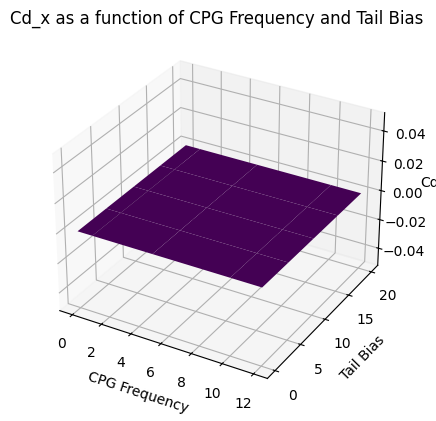

In [62]:
# 拟合系数 Cd_x(cpg_freq, tail_bias),
# 使用glob获取所有csv文件路径
Tail_freq_list = [0]
Tail_biases_list = [0, 5, 10, 15, 20]
CPG_freq_list = [0, 1, 5, 10, 12]

Force_pec = [0, 1.05, 2.5, 4.75]
Cd_x = np.zeros([len(CPG_freq_list), len(Tail_biases_list)])

for tail_freq in Tail_freq_list:
	for tail_bias_id, tail_bias in enumerate(Tail_biases_list):
		for cpg_freq_id, cpg_freq in enumerate(CPG_freq_list):
			csv_file = glob.glob(folder_path + "/" + str(tail_freq) + '-' + str(cpg_freq) + '-' + str(tail_bias)+".csv")
			if len(csv_file) != 0:
				print(csv_file)
				df = pd.read_csv(csv_file[0], header=None, names=['timestamp', 'state0','state1','state2', 'head_x', 'head_y', 'tail_x', 'tail_y'])
				df = df[((df['head_x'].diff().abs()>=1) |
						(df['head_y'].diff().abs()>=1)) ]
				
				df['head_x'] = df['head_x'] / 515 * 2
				df['head_y'] = df['head_y'] / 515 * 2
				df['tail_x'] = df['tail_x'] / 515 * 2
				df['tail_y'] = df['tail_y'] / 515 * 2

				# 示例路径点数据（二维点集，包含噪点）
				path_points_x = np.array(df['tail_x'])
				path_points_y = np.array(df['tail_y'])
				tail_points = np.column_stack((path_points_x, path_points_y))
				path_points_x = np.array(df['head_x'])
				path_points_y = np.array(df['head_y'])
				head_points = np.column_stack((path_points_x, path_points_y))
				timestamps = np.array(df['timestamp'])
				robot_points = (head_points) # + tail_points)/2

				avg_stable_velocity_fowards, avg_stable_curvatures, avg_stable_omegas, avg_stable_angles, stable_velocity_fowards, stable_curvatures, stable_omegas, stable_angles, velocity_fowards = calculate_curvature_and_angles(head_points, timestamps)

				Force = Force_pec[cpg_freq_id]
				Cd_x[cpg_freq_id, tail_bias_id] = Force / 500 / avg_stable_velocity_fowards**2
				print()

	# 绘制三维图
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# 生成网格数据
tail_bias_grid, cpg_freq_grid = np.meshgrid(Tail_biases_list, CPG_freq_list)

# 绘制Cd_x的曲面图
ax.plot_surface(cpg_freq_grid, tail_bias_grid, Cd_x, cmap='viridis')

# 设置标签
ax.set_xlabel('CPG Frequency')
ax.set_ylabel('Tail Bias')
ax.set_zlabel('Cd_x')

plt.title('Cd_x as a function of CPG Frequency and Tail Bias')
plt.show()
